In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error

In [ ]:
# Getting the data from yahoo finanace
# Define the ticker symbol and date range

ticker_symbol = "SBRY.L"
"""
".L" for London Stock Exchange
"""
start_date = "2011-01-01"
end_date = "2023-12-08"

# Download historical data
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Save data to a CSV file
stock_data.to_csv("Sainsbury's_stock_data.csv")

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
           # 80% for training, 20% for testing
train_data = scaled_data[0:train_size, :]
test_data =  scaled_data[train_size:len(scaled_data), :]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Define the generator and it's parameters
sequence_length = 15
train_batch_size = 20
test_batch_size = 6

train_generator = TimeseriesGenerator(train_data, train_data, \
                                      length=sequence_length, \
                                      batch_size=train_batch_size)

test_generator = TimeseriesGenerator(test_data, test_data, \
                                     length=sequence_length, \
                                     batch_size=test_batch_size)

print("\nTrain generator length:", train_generator)
print("Test generator length:", len(test_generator))

[*********************100%%**********************]  1 of 1 completed

Train data shape: (2613, 1)
Test data shape: (654, 1)

Train generator length: <keras.src.preprocessing.sequence.TimeseriesGenerator object at 0x78003b6ce5f0>
Test generator length: 107


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 15, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 15, 90)            11790     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 70)                11270     
                                                                 
 dense (Dense)               (None, 1)                 71        
                                                                 
Total params: 24811 (96.92 KB)
Trainable params: 24811 (96.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/250
130/130 [==============================] - 9s 38ms/step - loss: 0.0071
Epoch 2/250
130/130 [==============================] - 4s 34ms/step -

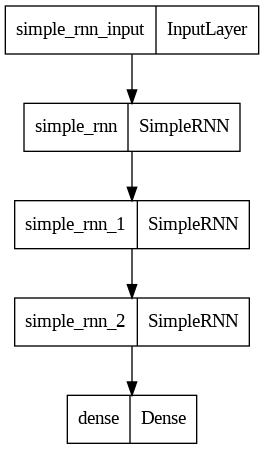

In [ ]:
# Building the 1st model using the RNN model
model_1_rnn = Sequential()

# Adding the SimpleRNN layer with 40, 90 and 70 units
model_1_rnn.add(SimpleRNN(units=40, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model_1_rnn.add(SimpleRNN(units=90, return_sequences=True, activation='relu'))
model_1_rnn.add(SimpleRNN(units=70, activation='relu'))

# Adding a Dense layer with one unit (for regression)
model_1_rnn.add(Dense(units=1))

# Compile the model
model_1_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_1_rnn.summary()

# Train the model for more epochs
model_1_rnn.fit(train_generator, epochs=250)
plot_model(model_1_rnn, to_file="model_1_rnn_plot.png", show_layer_names=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 15, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 120)               82080     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 121       
                                                                 
Total params: 153201 (598.44 KB)
Trainable params: 153201 (598.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
13

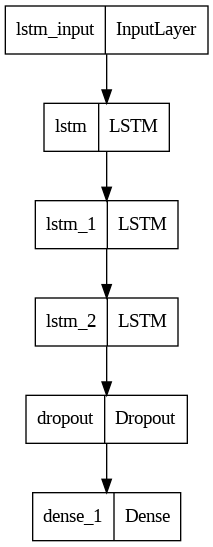

In [ ]:
# Building the 2nd model using LSTM model
model_2_lstm = Sequential()

# Adding an LSTM layer with 100 units
model_2_lstm.add(LSTM(units=100, activation='relu', return_sequences=True, \
                    input_shape=(sequence_length, 1)))

# Adding the another LSTM layer with 50 and 120 units
model_2_lstm.add(LSTM(units=50, activation='relu', return_sequences=True))
model_2_lstm.add(LSTM(units=120, activation='relu'))
model_2_lstm.add(Dropout(0.2))

# Adding a Dense layer with one unit (for regression)
model_2_lstm.add(Dense(units=1))

# Compile the model
model_2_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Display the model_2_lstm
model_2_lstm.summary()
model_2_lstm.fit(train_generator, epochs = 100)
plot_model(model_2_lstm, to_file="model_2_lstm_plot.png", show_layer_names=True)

In [ ]:
rnn_predictions = model_1_rnn.predict(test_generator)
lstm_predictions = model_2_lstm.predict(test_generator)

# Invert predictions for RNN and LSTM
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# making actuall prices
actual_prices = scaler.inverse_transform(test_data[sequence_length:])

# Print or visualize the predicted and true prices
print("Predicted Prices (RNN):", rnn_predictions.flatten())
print("Predicted Prices (LSTM):", lstm_predictions.flatten())
print("Actual_Prices:", actual_prices.flatten())

107/107 [==============================] - 1s 9ms/step
Predicted Prices (RNN): [265.6766  265.416   267.53836 267.53906 269.48917 265.10532 263.14523
 263.4918  262.1254  253.83191 252.15149 254.18358 254.0058  256.4294
 258.98105 259.80316 269.5457  269.52417 268.99884 272.0444  271.54694
 269.58444 268.4869  271.68454 271.96317 271.57303 277.84558 279.49585
 284.84943 283.19043 283.73117 282.92865 282.7938  282.4665  284.43628
 284.14856 280.687   278.06522 279.61224 280.562   278.7136  279.19778
 281.3736  281.2968  283.6706  282.90933 284.83054 291.66556 287.83905
 287.45676 288.50735 290.67084 293.45285 302.05606 302.97653 301.5133
 297.91943 295.63297 290.53018 289.0689  294.6131  341.91068 319.09207
 321.2575  319.4942  310.90515 303.44104 306.34195 304.1083  303.38116
 303.02698 301.03696 301.03302 296.59094 293.90558 290.49234 289.2039
 285.4895  281.7894  282.252   286.82693 292.1576  295.2592  295.18524
 294.9556  291.5392  291.9528  290.28763 285.10724 284.22678 294.10327
 

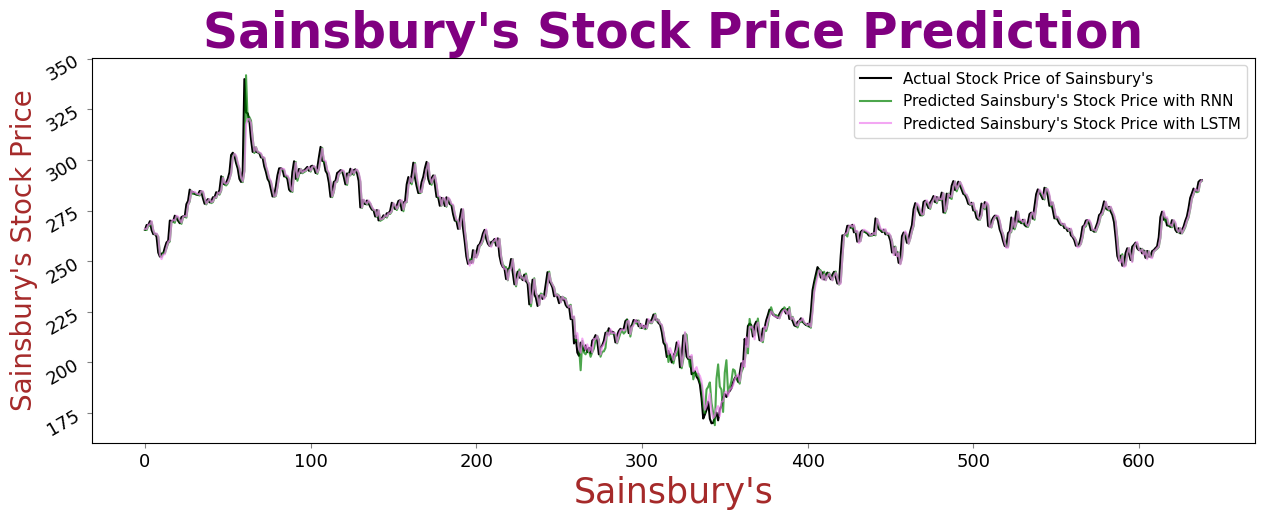

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the data
plt.figure(figsize=(15,5))
plt.plot(actual_prices, "k-", label="Actual Stock Price of Sainsbury's")
# "k-" shows solid line style with black color
plt.plot(rnn_predictions, color ='green', alpha=0.7, label="Predicted Sainsbury's Stock Price with RNN")
plt.plot(lstm_predictions, color ='violet', alpha=0.7, label="Predicted Sainsbury's Stock Price with LSTM")
plt.title("Sainsbury's Stock Price Prediction", color = "purple", size = 35, weight='bold')
plt.tick_params(axis='x', labelsize=13,color = "grey")
plt.xlabel("Sainsbury's", size = 25,  color = "brown")
plt.tick_params(axis='y', labelrotation=30, labelsize=13,color = "grey")
plt.ylabel("Sainsbury's Stock Price", size = 20, color = "brown")
plt.legend(fontsize=11)
plt.show()
plt.savefig("Model_prediction.jpeg")



In [ ]:
def predict_future_days(model, base_data, days_to_predict, scaler, look_back=2000):
    # Start with the last days of the base data
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # Predict future days
    future_predictions = []

    for _ in range(days_to_predict):
        # Make a prediction
        prediction = model.predict(input_data)

        # Append the prediction
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        # Correctly reshape the prediction to (1, 1, 1) before appending
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions



1/1 [==============================] - 0s 23ms/step


<ipython-input-19-ce90d2434a4e>:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=stock_data.index[-1], periods=days_to_predict + 1, closed='right')


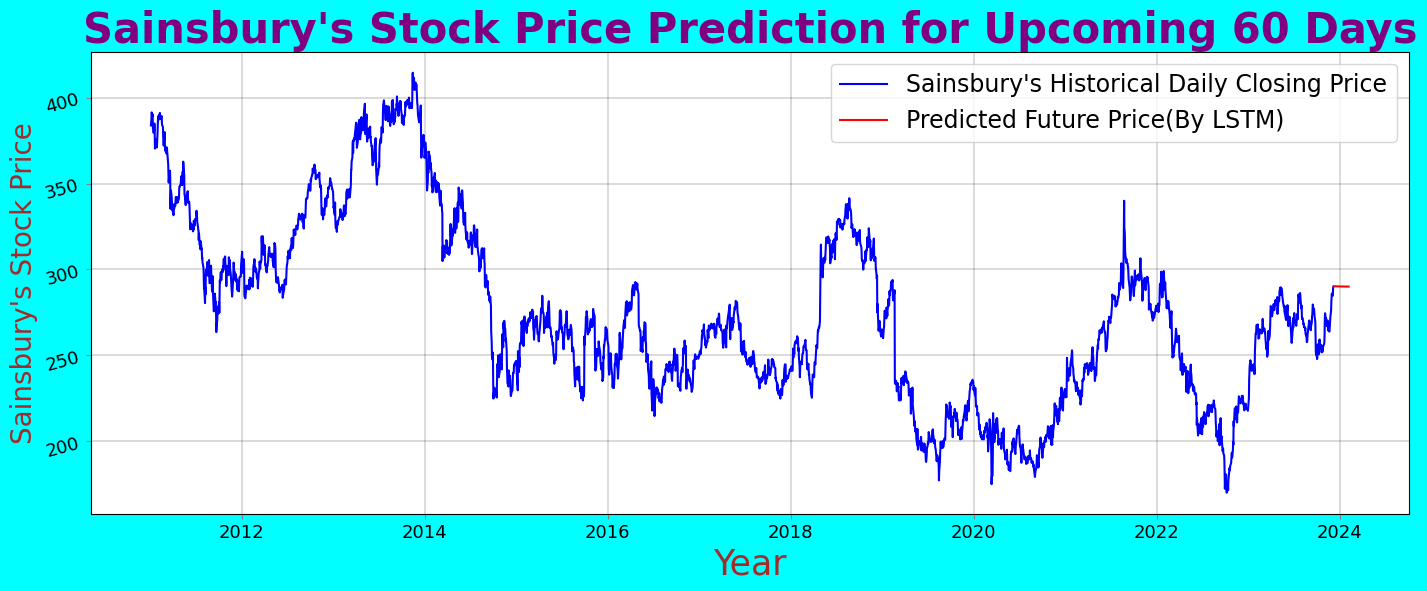

<Figure size 640x480 with 0 Axes>

In [ ]:
days_to_predict = 60
future_days = predict_future_days(model_2_lstm, scaled_data, days_to_predict, scaler, sequence_length)
predicted_dates = pd.date_range(start=stock_data.index[-1], periods=days_to_predict + 1, closed='right')
plt.figure(figsize=(17,6), facecolor='cyan')
plt.plot(stock_data.index, stock_data['Close'], color='blue', label="Sainsbury's Historical Daily Closing Price")
plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price(By LSTM)')
plt.title(f"Sainsbury's Stock Price Prediction for Upcoming {days_to_predict} Days",weight="bold", color = "purple", size = 30)
plt.xlabel('Year', size = 25, color = "brown")
plt.tick_params(axis='x', labelsize=13,color = "grey")
plt.ylabel("Sainsbury's Stock Price", size = 20, color = "brown")
plt.tick_params(axis='y', labelrotation=15, labelsize=13,color = "grey")
plt.legend(fontsize=17)
plt.grid(color='black', linestyle='-', linewidth=0.2)
plt.show()
plt.savefig("Future_prediction.jpeg")

In [ ]:
mse = mean_squared_error(actual_prices, lstm_predictions)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 4.130261848825099
